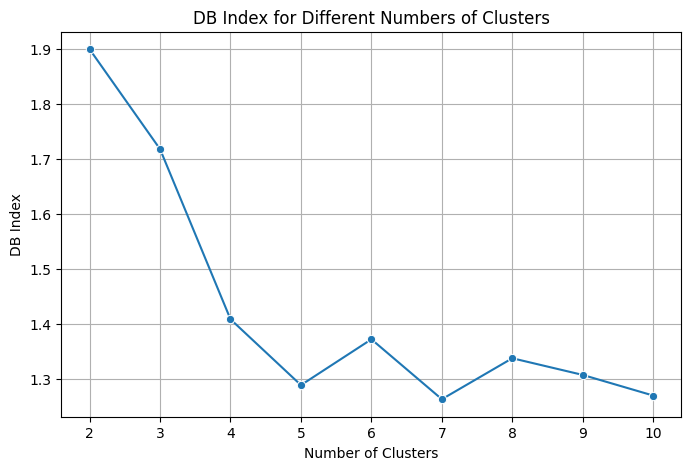

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_path = 'Customers.csv'
transactions_path = 'Transactions.csv'
products_path = 'Products.csv'

customers_df = pd.read_csv('/content/Customers.csv')
transactions_df = pd.read_csv('/content/Transactions - Transactions.csv')
products_df = pd.read_csv('/content/Products.csv')

# Convert dates to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merge datasets
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')
merged_df = merged_df.merge(products_df, on='ProductID', how='left')

# Feature Engineering
total_spending = merged_df.groupby('CustomerID')['TotalValue'].sum().rename('TotalSpending')
avg_transaction_value = merged_df.groupby('CustomerID')['TotalValue'].mean().rename('AvgTransactionValue')
transaction_frequency = merged_df.groupby('CustomerID')['TransactionID'].count().rename('TransactionFrequency')
category_preferences = merged_df.pivot_table(index='CustomerID', columns='Category',
                                             values='Quantity', aggfunc='sum', fill_value=0)
category_preferences = category_preferences.div(category_preferences.sum(axis=1), axis=0)

# Combine features
features_df = pd.concat([total_spending, avg_transaction_value, transaction_frequency, category_preferences], axis=1)

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Clustering and DB Index calculation
db_indices = []
kmeans_models = {}

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    db_index = davies_bouldin_score(features_scaled, cluster_labels)

    db_indices.append((n_clusters, db_index))
    kmeans_models[n_clusters] = (kmeans, cluster_labels)

# Find the optimal number of clusters
db_indices_sorted = sorted(db_indices, key=lambda x: x[1])
optimal_clusters = db_indices_sorted[0][0]

# Visualize DB Index
clusters, db_values = zip(*db_indices)
plt.figure(figsize=(8, 5))
sns.lineplot(x=clusters, y=db_values, marker='o')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(range(2, 11))
plt.grid()
plt.show()



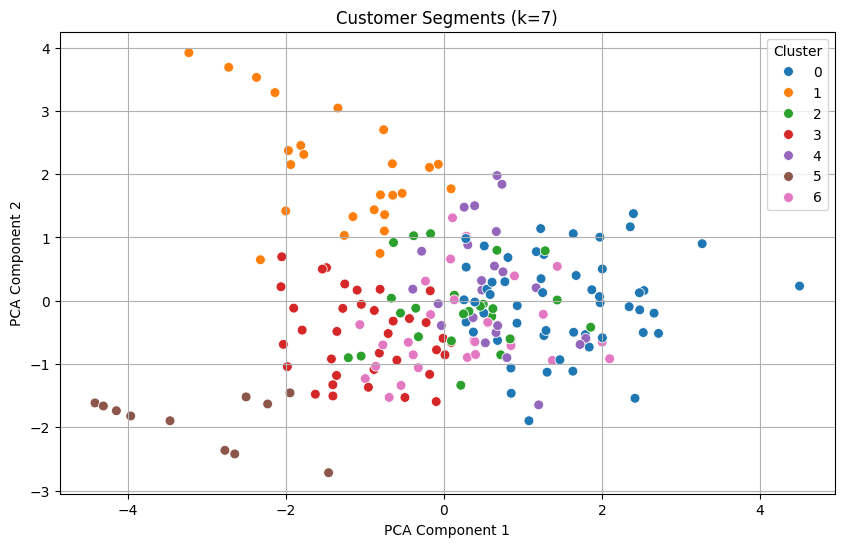

In [2]:
# Visualize Clusters (e.g., using the first two PCA components)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
optimal_kmeans, cluster_labels = kmeans_models[optimal_clusters]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=cluster_labels, palette='tab10', s=50)
plt.title(f'Customer Segments (k={optimal_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Save clustering results
features_df['Cluster'] = cluster_labels
features_df.to_csv('customer_segmentation_results.csv', index=True)
